## Proyecto integrador - Modelo

In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import random
import geopy.distance
from sklearn.covariance import LedoitWolf
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn import linear_model

### Funciones Auxilirares

In [86]:
#Distancia linea recta
def p_distance_function(x1, y1, x2, y2,p):
    dist = (np.abs(x2-x1)**p + np.abs(y2-y1)**p)**1/p
    return dist

# Distancia de Mahalanobis General
def Mahalanobis(data):
    y_mu = data - np.mean(data)
    cov = np.cov(data.values.T)
    inv_cov = np.linalg.inv(cov)
    M = np.dot(y_mu, inv_cov)
    mahal = np.dot(M, y_mu.T)
    return mahal.diagonal()

# Distancia de Mahalanobis para un par de puntos
def distance_mahalanobis(x1,y1,x2,y2,cov):
    
    y_mu = np.array([x1, y1]) - np.array([x2, y2])
    inv_cov = np.linalg.inv(cov)
    M = np.dot(y_mu, inv_cov)
    distance = np.dot(M, y_mu.T)
    
    return distance

#Regression lineal
def regression(df): 
    
    #df: features, Matriz de los datos
    
    M = df.copy()
    y = M[['y_delay']]
    M['unos'] = 1
    M = M[['unos','AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
    MT = np.transpose(M)
    C = np.dot(MT,M)
    print('det',np.linalg.det(C))
    CI = np.linalg.inv(C)
    A = np.dot(CI,MT) #Pseudo inversa
    b = np.dot(A,y)   #Betas que ajustan la ecuacion
    print('Betas',b)
    y_pred = np.dot(M,b)

    return b, y_pred

### Leer el dataframe de la zona Trusted

In [3]:
if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x

client = boto3.client('s3')
bucket_name = 'prr-integrador-grupo3'

object_key1 = 'Zona-trusted/df_COMMUTER_ENTRY.csv'
csv_obj1 = client.get_object(Bucket=bucket_name, Key=object_key1)
body1 = csv_obj1['Body']
csv_string1 = body1.read().decode('utf-8')
data = pd.read_csv(StringIO(csv_string1))


### Análisis exploratorio

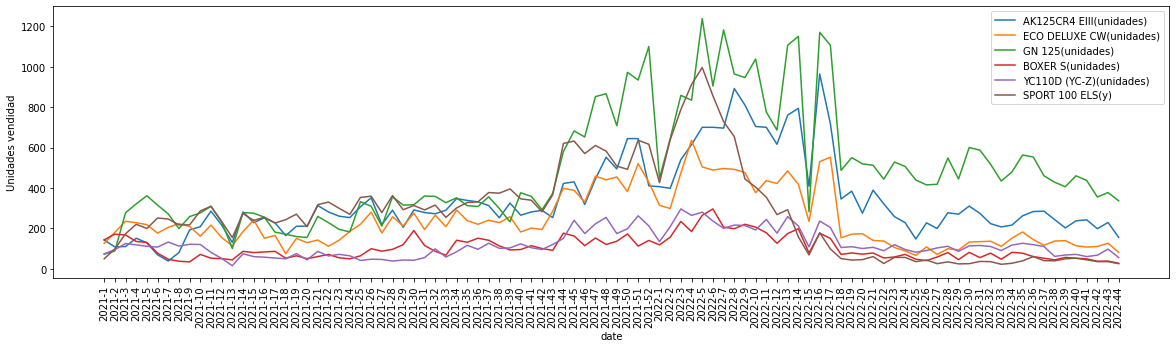

In [4]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(data.date, data['AK125CR4 EIII(unidades)'], label = 'AK125CR4 EIII(unidades)')
ax.plot(data.date, data['ECO DELUXE CW(unidades)'], label = 'ECO DELUXE CW(unidades)')
ax.plot(data.date, data['GN 125(unidades)'], label = 'GN 125(unidades)')
ax.plot(data.date, data['BOXER S(unidades)'], label = 'BOXER S(unidades)')
ax.plot(data.date, data['YC110D (YC-Z)(unidades)'], label = 'YC110D (YC-Z)(unidades)')
ax.plot(data.date, data['SPORT 100 ELS(y)'], label = 'SPORT 100 ELS(y)')
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('Unidades vendidad')
plt.legend()
plt.show()

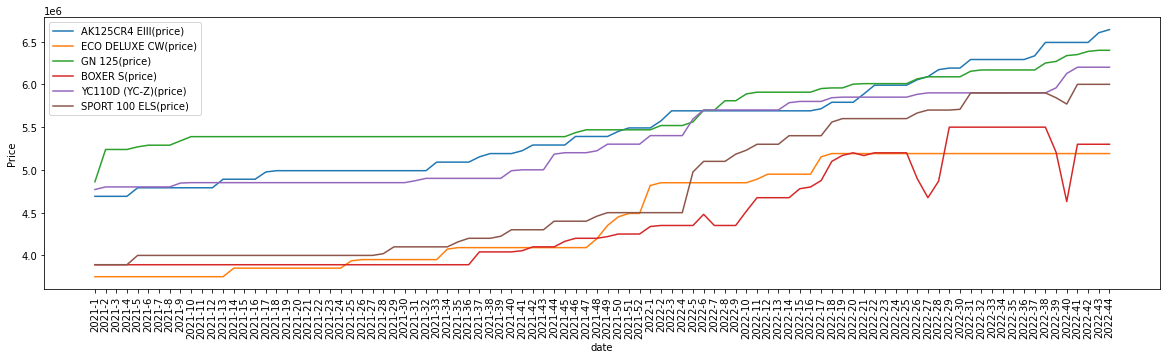

In [5]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(data.date, data['AK125CR4 EIII(price)'], label = 'AK125CR4 EIII(price)')
ax.plot(data.date, data['ECO DELUXE CW(price)'], label = 'ECO DELUXE CW(price)')
ax.plot(data.date, data['GN 125(price)'], label = 'GN 125(price)')
ax.plot(data.date, data['BOXER S(price)'], label = 'BOXER S(price)')
ax.plot(data.date, data['YC110D (YC-Z)(price)'], label = 'YC110D (YC-Z)(price)')
ax.plot(data.date, data['SPORT 100 ELS(price)'], label = 'SPORT 100 ELS(price)')
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
# Generamos un delay de 1 semana en los datos
y_delay = []
for i in range(1,len(data)):
    y_delay.append(data['SPORT 100 ELS(y)'][i])
data = data[:-1]
data['y_delay'] = y_delay

In [7]:
data.head(5)

,date,AK125CR4 EIII(price),ECO DELUXE CW(price),GN 125(price),BOXER S(price),YC110D (YC-Z)(price),AK125CR4 EIII(unidades),ECO DELUXE CW(unidades),GN 125(unidades),BOXER S(unidades),YC110D (YC-Z)(unidades),SPORT 100 ELS(y),SPORT 100 ELS(price),y_delay
0,2021-1,4690000.0,3750000.0,4.860694e+06,3890000.0,4.769595e+06,142,126,72,143,74,49,3890000.0,98
1,2021-2,4690000.0,3750000.0,5.238000e+06,3890000.0,4.800000e+06,108,180,88,171,94,98,3890000.0,173
2,2021-3,4690000.0,3750000.0,5.238000e+06,3890000.0,4.800000e+06,110,235,277,167,125,173,3890000.0,220
3,2021-4,4690000.0,3750000.0,5.238000e+06,3890000.0,4.800000e+06,151,228,321,135,118,220,3890000.0,199
4,2021-5,4790000.0,3750000.0,5.268362e+06,3890000.0,4.800000e+06,128,218,361,130,111,199,3999000.0,251


### Correlacón entre cada variable

In [8]:
corr_df = data.corr(method='pearson')
corr_df

,AK125CR4 EIII(price),ECO DELUXE CW(price),GN 125(price),BOXER S(price),YC110D (YC-Z)(price),AK125CR4 EIII(unidades),ECO DELUXE CW(unidades),GN 125(unidades),BOXER S(unidades),YC110D (YC-Z)(unidades),SPORT 100 ELS(y),SPORT 100 ELS(price),y_delay
AK125CR4 EIII(price),1.000000,0.951106,0.952689,0.932518,0.962743,0.216070,-0.076084,0.414783,-0.117691,0.195174,-0.310035,0.964527,-0.342456
ECO DELUXE CW(price),0.951106,1.000000,0.922945,0.924588,0.978370,0.344853,0.028953,0.514319,0.004407,0.296457,-0.280596,0.964374,-0.318966
GN 125(price),0.952689,0.922945,1.000000,0.934788,0.952807,0.155647,-0.187092,0.319883,-0.234955,0.058269,-0.485773,0.974820,-0.537253
BOXER S(price),0.932518,0.924588,0.934788,1.000000,0.927179,0.099330,-0.198970,0.311023,-0.224460,0.100104,-0.490527,0.963499,-0.515754
YC110D (YC-Z)(price),0.962743,0.978370,0.952807,0.927179,1.000000,0.327699,0.008808,0.506730,-0.029536,0.279790,-0.311006,0.982750,-0.365511
AK125CR4 EIII(unidades),0.216070,0.344853,0.155647,0.099330,0.327699,1.000000,0.840592,0.868605,0.715344,0.780270,0.529140,0.224756,0.408325
ECO DELUXE CW(unidades),-0.076084,0.028953,-0.187092,-0.198970,0.008808,0.840592,1.000000,0.779961,0.803011,0.842989,0.764829,-0.108630,0.678798
GN 125(unidades),0.414783,0.514319,0.319883,0.311023,0.506730,0.868605,0.779961,1.000000,0.652511,0.860528,0.469400,0.411163,0.336432
BOXER S(unidades),-0.117691,0.004407,-0.234955,-0.224460,-0.029536,0.715344,0.803011,0.652511,1.000000,0.716350,0.700281,-0.127504,0.625753
YC110D (YC-Z)(unidades),0.195174,0.296457,0.058269,0.100104,0.279790,0.780270,0.842989,0.860528,0.716350,1.000000,0.633050,0.171205,0.548754


<AxesSubplot:>

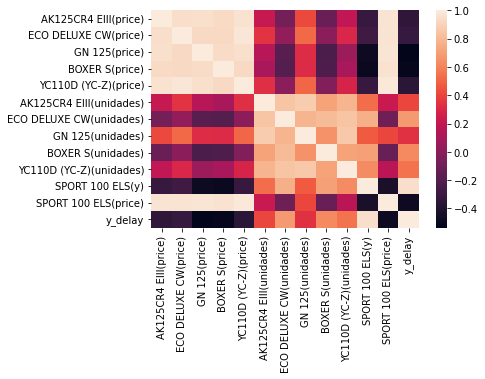

In [9]:
sns.heatmap(corr_df)

In [10]:
#Elegimos las columnas que mas se correlacionan con y_delay y renombramos las columnas
data = data[['AK125CR4 EIII(unidades)','ECO DELUXE CW(unidades)', 'GN 125(unidades)', 'BOXER S(unidades)', 'YC110D (YC-Z)(unidades)', 'SPORT 100 ELS(y)', 'y_delay']]
data = data.rename(columns = {'AK125CR4 EIII(unidades)': 'AKT', 'ECO DELUXE CW(unidades)': 'HERO','GN 125(unidades)': 'SUSUKI','BOXER S(unidades)': 'UMA','YC110D (YC-Z)(unidades)': 'YAMAHA','SPORT 100 ELS(y)': 'AUTECO'})

### Coeficientes de correlación múltiple entre cada variable y resto

In [11]:
S = data.cov().values
SI = np.linalg.inv(S)
r = 1 - (1/(np.diag(S)*np.diag(SI)))
for i in range(len(data.columns)):
    print('{} = {}'.format(data.columns[i],r[i]))

AKT = 0.8394465017932664
HERO = 0.879446808686992
SUSUKI = 0.865823057344329
UMA = 0.6808204128693773
YAMAHA = 0.8360342875165896
AUTECO = 0.9302580352446316
y_delay = 0.9190488583328882


In [12]:
data

,AKT,HERO,SUSUKI,UMA,YAMAHA,AUTECO,y_delay
0,142,126,72,143,74,49,98
1,108,180,88,171,94,98,173
2,110,235,277,167,125,173,220
3,151,228,321,135,118,220,199
4,128,218,361,130,111,199,251
...,...,...,...,...,...,...,...
90,202,139,406,56,68,49,52
91,237,114,460,52,71,52,44
92,242,107,437,49,60,44,35
93,198,110,355,37,67,35,35


In [13]:
index_1 = list(data[(data.y_delay < 100)].sample(4).index)
index_2 = list(data[(data.y_delay > 100) & (data.y_delay < 500)].sample(3).index)
index_3 = list(data[(data.y_delay > 500)].sample(3).index)
index = index_1 + index_2 + index_3

In [14]:
## Sacamos 10 semanas aleatorias para probar el modelo
data_test = data[(data.index.isin(index))].reset_index(drop=True)
data_train = data[~(data.index.isin(index))].reset_index(drop=True)

### Encontremos los Betas que describren el Sistema

#### Regresion lineal

In [88]:
#Regression lineal
def regression(df): 
    
    #df: features, Matriz de los datos
    
    M = df.copy()
    y = M[['y_delay']]
    M['unos'] = 1
    M = M[['unos','AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
    MT = np.transpose(M)
    C = np.dot(MT,M)
    print('det',np.linalg.det(C))
    CI = np.linalg.inv(C)
    A = np.dot(CI,MT) #Pseudo inversa
    b = np.dot(A,y)   #Betas que ajustan la ecuacion
    print('Betas',b)
    y_pred = np.dot(M,b)

    return b, y_pred

In [16]:
betas,y_pred = regression(data_train)

det 1.5280907884601725e+36
Betas [[ 3.33060451e+01]
 [-9.01370778e-02]
 [ 1.57237732e-02]
 [-1.41492851e-01]
 [ 1.85488736e-01]
 [ 4.08333390e-01]
 [ 9.81147140e-01]]


In [17]:
MAE = mean_absolute_error(data_train['y_delay'],y_pred)
MAPE = mean_absolute_percentage_error(data_train['y_delay'],y_pred)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

MAE = 42.10076688546461, MAPE = 0.21833236344010762


In [18]:
# Evaluamos las predicciones del test
M_test = data_test.copy()
M_test['unos'] = 1
M_test = M_test[['unos','AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
y_pred_test = np.dot(M_test,betas)

In [19]:
M_test['y'] = data_test['y_delay']
M_test['y_pred'] = y_pred_test
M_test

,unos,AKT,HERO,SUSUKI,UMA,YAMAHA,AUTECO,y,y_pred
0,1,151,228,321,135,118,220,199,266.937852
1,1,285,216,309,52,81,309,234,313.186907
2,1,307,220,332,64,41,353,359,337.075454
3,1,406,314,448,118,134,426,638,432.831886
4,1,700,504,1238,264,280,996,856,943.491650
5,1,700,488,904,296,236,856,728,841.107053
6,1,345,153,487,71,105,50,43,40.809536
7,1,384,171,550,78,109,43,45,24.726893
8,1,199,71,418,58,103,25,34,34.686507
9,1,207,111,434,47,90,22,27,22.038324


In [20]:
MAE = mean_absolute_error(M_test['y'],y_pred_test)
MAPE = mean_absolute_percentage_error(M_test['y'],y_pred_test)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

MAE = 60.292787629685755, MAPE = 0.20254414867575754


#### Regresion ridge

In [21]:
X_train = data_train[['AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
Y_train = data_train[['y_delay']]
X_test = data_test[['AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
Y_test = data_test[['y_delay']]

In [22]:
alphas = np.linspace(0,2,100)
MAE_trainlist = []
MAE_testlist = []
for alpha in alphas:
    modeloridge = linear_model.Ridge(alpha=alpha)
    modeloridge.fit(X_train , Y_train)
    y_train_pred = modeloridge.predict(X_train)
    y_test_pred = modeloridge.predict(X_test)
    MAE_trainlist.append(mean_absolute_error(data_train['y_delay'],y_train_pred))
    MAE_testlist.append(mean_absolute_error(data_test['y_delay'],y_test_pred))

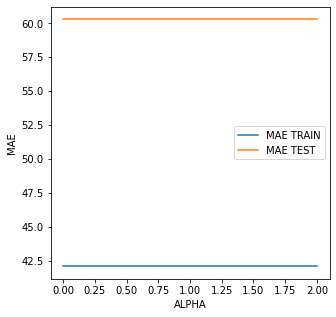

In [23]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(alphas, MAE_trainlist, label = 'MAE TRAIN')
ax.plot(alphas, MAE_testlist, label = 'MAE TEST')
plt.xlabel('ALPHA')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [24]:
modeloridge = linear_model.Ridge(alpha=0.5)
modeloridge.fit(X_train , Y_train)

Ridge(alpha=0.5)

In [25]:
y_train_pred = modeloridge.predict(X_train)
y_test_pred = modeloridge.predict(X_test)

In [26]:
#Train
MAE = mean_absolute_error(data_train['y_delay'],y_train_pred)
MAPE = mean_absolute_percentage_error(data_train['y_delay'],y_train_pred)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

MAE = 42.100746087756065, MAPE = 0.21833210900844668


In [27]:
#Test
#Train
MAE = mean_absolute_error(data_test['y_delay'],y_test_pred)
MAPE = mean_absolute_percentage_error(data_test['y_delay'],y_test_pred)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

MAE = 60.292721102332095, MAPE = 0.20254368100400072


### Eliminamos outliers usando la distancia de Mahalanobis

In [28]:
distance_Mahalanobis = Mahalanobis(data_train)
data_train['distancia'] = distance_Mahalanobis
q_mahalanobis = data_train['distancia'].quantile(0.8)
data_train = data_train[(data_train.distancia < q_mahalanobis)].reset_index(drop=True)

/home/simon/anaconda3/envs/eafit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [29]:
data_train

,AKT,HERO,SUSUKI,UMA,YAMAHA,AUTECO,y_delay,distancia
0,128,218,361,130,111,199,251,6.533920
1,69,176,315,77,107,251,246,4.865540
2,38,205,271,47,132,246,217,11.003582
3,80,223,199,37,112,217,217,9.807459
4,192,209,258,34,121,217,286,6.507532
...,...,...,...,...,...,...,...,...
63,202,139,406,56,68,49,52,2.283497
64,237,114,460,52,71,52,44,2.622293
65,242,107,437,49,60,44,35,2.915789
66,198,110,355,37,67,35,35,2.096966


In [30]:
betas,y_pred = regression(data_train)

det 1.8749506582247955e+34
Betas [[ 4.41685606e+01]
 [-3.82839610e-02]
 [ 1.28857207e-01]
 [-1.47939555e-01]
 [ 2.96069865e-01]
 [ 8.81917102e-02]
 [ 8.60615039e-01]]


In [31]:
MAE = mean_absolute_error(data_train['y_delay'],y_pred)
MAPE = mean_absolute_percentage_error(data_train['y_delay'],y_pred)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

MAE = 30.826348653215124, MAPE = 0.21318947894060147


In [32]:
# Evaluamos las predicciones del test
M_test = data_test.copy()
M_test['unos'] = 1
M_test = M_test[['unos','AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
y_pred_test = np.dot(M_test,betas)

In [33]:
M_test['y'] = data_test['y_delay']
M_test['y_pred'] = y_pred_test
M_test

,unos,AKT,HERO,SUSUKI,UMA,YAMAHA,AUTECO,y,y_pred
0,1,151,228,321,135,118,220,199,259.989891
1,1,285,216,309,52,81,309,234,303.846674
2,1,307,220,332,64,41,353,359,338.009478
3,1,406,314,448,118,134,426,638,416.185454
4,1,700,504,1238,264,280,996,856,859.193353
5,1,700,488,904,296,236,856,728,791.651144
6,1,345,153,487,71,105,50,43,51.941025
7,1,384,171,550,78,109,43,45,39.848139
8,1,199,71,418,58,103,25,34,31.631354
9,1,207,111,434,47,90,22,27,27.127232


In [34]:
MAE = mean_absolute_error(M_test['y'],y_pred_test)
MAPE = mean_absolute_percentage_error(M_test['y'],y_pred_test)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

MAE = 45.70748931098008, MAPE = 0.14990714561998822


## Aplicamos PCA

In [35]:
X = data_train[['AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
y = data_train[['y_delay']]

#Scaler
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

#Estandarizamos los datos
X_scaler = scaler.fit_transform(X.values)
Y_scaler = y_scaler.fit_transform(y.values)

In [36]:
#Aplicamos PCA a los datos
pca = PCA(n_components=2)
pca.fit(X_scaler)

PCA(n_components=2)

In [37]:
print('Varianza explicada por las dos primeras componentes:',sum(pca.explained_variance_ratio_))

Varianza explicada por las dos primeras componentes: 0.890050932546387


In [38]:
#Calculemos Z1 y Z2
Z1 = X_scaler @ pca.components_[0]
Z2 = X_scaler @ pca.components_[1]

Text(0, 0.5, 'Z2')

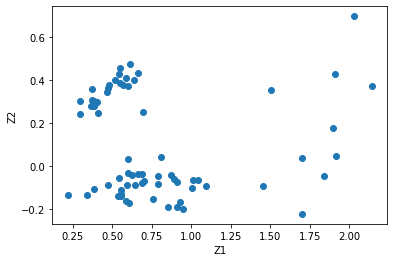

In [39]:
plt.plot(Z1,Z2,'o')
plt.xlabel('Z1')
plt.ylabel('Z2')

In [40]:
def regression_z(df): 
    
    #df: features, Matriz de los datos
    
    M = df.copy()
    y = M[['y']]
    M['unos'] = 1
    M = M[['unos','Z1', 'Z2']]
    MT = np.transpose(M)
    C = np.dot(MT,M)
    print('det',np.linalg.det(C))
    CI = np.linalg.inv(C)
    A = np.dot(CI,MT) #Pseudo inversa
    b = np.dot(A,y)   #Betas que ajustan la ecuacion
    print('Betas',b)
    y_pred = np.dot(M,b)

    return b, y_pred

In [41]:
data_z = pd.DataFrame()
data_z['Z1'] = Z1
data_z['Z2'] = Z2
data_z['y']  = Y_scaler

In [42]:
betas_z, y_pred_z = regression_z(data_z)

det 3820.016518842011
Betas [[ 0.10726161]
 [ 0.39253378]
 [-0.75554079]]


In [43]:
y_pred_z = y_scaler.inverse_transform(y_pred_z)

In [44]:
MAE = mean_absolute_error(y,y_pred_z)
MAPE = mean_absolute_percentage_error(y,y_pred_z)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

MAE = 33.896401620671426, MAPE = 0.2280654037232417


<AxesSubplot:xlabel='Z1', ylabel='Z2'>

<Figure size 720x720 with 0 Axes>

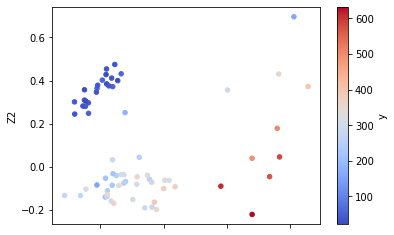

In [45]:
plt.figure(figsize=(10,10))
data_z['y']  = y
data_z.plot.scatter(x='Z1',y='Z2',c='y', cmap='coolwarm')

# Clusterizacion

In [46]:
df_sample = data_z[['Z1','Z2']]
df_sample  = df_sample.rename(columns = {'Z1': 'x', 'Z2': 'y'})

In [47]:
def K_means(df_sample,n_clusters,p_distance,iterations): # DataFrame, Numero de grupos, distancia p, iteraciones
    
    
    df = df_sample.copy()
    cov_sample = np.cov(df.values.T) # Calculamos la matriz de covarianza de los datos
    x_centroids = [random.uniform(min(df_sample.x), max(df_sample.x)) for _ in range(n_clusters)]
    y_centroids = [random.uniform(min(df_sample.y), max(df_sample.y)) for _ in range(n_clusters)]
    
    for j in range(iterations):
        clusters = []
        for i in range(len(df)):
            x_ = df['x'][i]
            y_ = df['y'][i]
            
            centroids_distance = []
            for k_c in range(n_clusters):
                
                if p_distance == 0:
                    Distance = distance_mahalanobis(x_, y_, x_centroids[k_c], y_centroids[k_c], cov_sample)
                    centroids_distance.append(Distance)
                else:
                    Distance = p_distance_function(x_, y_, x_centroids[k_c], y_centroids[k_c], p_distance)
                    centroids_distance.append(Distance)
                    
                
            cluster_class = centroids_distance.index(min(centroids_distance))
            clusters.append(cluster_class)
            

        df['clusters'] = clusters
        
        x_centroids_tmp = []
        y_centroids_tmp = []
        
        for C in range(n_clusters):
            try:
                x_centroids_tmp.append(np.mean(df[(df.clusters == C)]['x'])) 
                y_centroids_tmp.append(np.mean(df[(df.clusters == C)]['y']))
            except:
                x_centroids_tmp.append(x_centroids[C]) 
                y_centroids_tmp.append(y_centroids[C])
                
        x_centroids = x_centroids_tmp
        y_centroids = y_centroids_tmp
        
    CENTROIDS = [x_centroids,y_centroids]
      
            
    return df, CENTROIDS

In [48]:
df_prueba , centros = K_means(df_sample, 3, 1, 100)  # DataFrame, Numero de grupos, distancia p, iteraciones

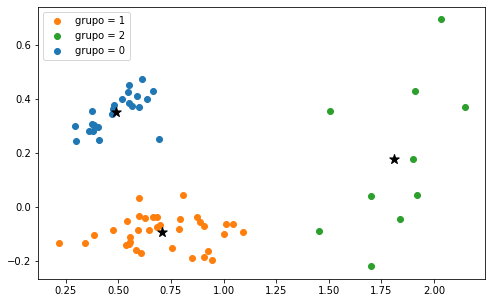

In [49]:
plt.figure(figsize=(8, 5))
for k in df_prueba.clusters.unique():
    df_tmp = df_prueba[(df_prueba.clusters == k)]
    plt.scatter(df_tmp['x'],df_tmp['y'], c='C{}'.format(k), label = 'grupo = {}'.format(k))
    plt.legend()
plt.scatter(centros[0],centros[1], s=100, marker = '*', c='black', label = 'Centros calculados')

In [50]:
df_grupo_0 = data_train[(data_train.index.isin(df_prueba[(df_prueba.clusters == 0)].index.unique()))].reset_index(drop=True)
df_grupo_1 = data_train[(data_train.index.isin(df_prueba[(df_prueba.clusters == 1)].index.unique()))].reset_index(drop=True)
df_grupo_2 = data_train[(data_train.index.isin(df_prueba[(df_prueba.clusters == 2)].index.unique()))].reset_index(drop=True)

In [51]:
print('Grupo 0')
betas_grupo_0,y_pred_grupo_0 = regression(df_grupo_0)
print('Grupo 1')
betas_grupo_1,y_pred_grupo_1 = regression(df_grupo_1)
print('Grupo 2')
betas_grupo_2,y_pred_grupo_2 = regression(df_grupo_2)

Grupo 0
det 9.323941765704345e+25
Betas [[23.80829223]
 [ 0.04495979]
 [ 0.39114169]
 [-0.20060695]
 [ 0.32214678]
 [ 0.13260893]
 [ 0.51744797]]
Grupo 1
det 7.42052184113673e+29
Betas [[ 1.63746804e+02]
 [ 1.77567893e-01]
 [-1.02127042e-01]
 [-2.25341273e-01]
 [ 7.20112330e-01]
 [ 3.05904206e-01]
 [ 2.83570110e-01]]
Grupo 2
det 3.748703948967694e+27
Betas [[ 2.69990252e+02]
 [ 9.71186199e-02]
 [-1.45856312e-01]
 [-7.49352138e-02]
 [-4.28841097e-01]
 [-9.77691746e-01]
 [ 1.07017707e+00]]


In [52]:
print('Grupo 0')
MAE = mean_absolute_error(df_grupo_0['y_delay'],y_pred_grupo_0)
MAPE = mean_absolute_percentage_error(df_grupo_0['y_delay'],y_pred_grupo_0)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))
print('Grupo 1')
MAE = mean_absolute_error(df_grupo_1['y_delay'],y_pred_grupo_1)
MAPE = mean_absolute_percentage_error(df_grupo_1['y_delay'],y_pred_grupo_1)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))
print('Grupo 2')
MAE = mean_absolute_error(df_grupo_2['y_delay'],y_pred_grupo_2)
MAPE = mean_absolute_percentage_error(df_grupo_2['y_delay'],y_pred_grupo_2)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

Grupo 0
MAE = 11.860225242444002, MAPE = 0.331542723021211
Grupo 1
MAE = 33.29477766954526, MAPE = 0.12496289623393309
Grupo 2
MAE = 16.51909579846214, MAPE = 0.04241387549507413


## Etiquetemos los dato que no ha visto

In [53]:
data_test

,AKT,HERO,SUSUKI,UMA,YAMAHA,AUTECO,y_delay
0,151,228,321,135,118,220,199
1,285,216,309,52,81,309,234
2,307,220,332,64,41,353,359
3,406,314,448,118,134,426,638
4,700,504,1238,264,280,996,856
5,700,488,904,296,236,856,728
6,345,153,487,71,105,50,43
7,384,171,550,78,109,43,45
8,199,71,418,58,103,25,34
9,207,111,434,47,90,22,27


In [54]:
X_test = data_test[['AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
y_test = data_test[['y_delay']]

In [55]:
#Estandarizamos los datos
X_scaler_test = scaler.transform(X_test.values)
Y_scaler_test = y_scaler.transform(y_test.values)

In [56]:
X_scaler_test

array([[ 0.14637306,  0.38755981,  0.21968191,  0.54301075,  0.42386831,
         0.32236842],
       [ 0.31994819,  0.35885167,  0.20775348,  0.09677419,  0.27160494,
         0.46875   ],
       [ 0.3484456 ,  0.36842105,  0.2306163 ,  0.16129032,  0.10699588,
         0.54111842],
       [ 0.47668394,  0.59330144,  0.34592445,  0.4516129 ,  0.48971193,
         0.66118421],
       [ 0.85751295,  1.04784689,  1.13121272,  1.23655914,  1.09053498,
         1.59868421],
       [ 0.85751295,  1.00956938,  0.79920477,  1.40860215,  0.90946502,
         1.36842105],
       [ 0.39766839,  0.20813397,  0.38469185,  0.19892473,  0.37037037,
         0.04276316],
       [ 0.44818653,  0.25119617,  0.4473161 ,  0.23655914,  0.38683128,
         0.03125   ],
       [ 0.20854922,  0.01196172,  0.31610338,  0.12903226,  0.36213992,
         0.00164474],
       [ 0.21891192,  0.1076555 ,  0.33200795,  0.06989247,  0.30864198,
        -0.00328947]])

In [57]:
#Calculemos Z1 y Z2
Z1_test = X_scaler_test @ pca.components_[0]
Z2_test = X_scaler_test @ pca.components_[1]

Text(0, 0.5, 'Z2')

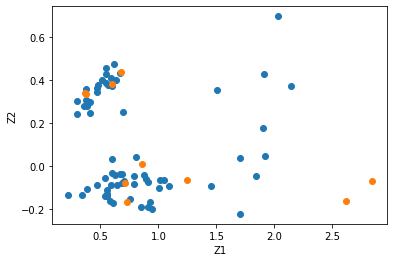

In [58]:
plt.scatter(Z1,Z2, c='C0' )
plt.scatter(Z1_test,Z2_test, c='C1')
plt.xlabel('Z1')
plt.ylabel('Z2')

In [59]:
df_Z_test = pd.DataFrame()
df_Z_test['Z1'] = Z1_test
df_Z_test['Z2'] = Z2_test

In [60]:
cluster_test = []
for i in range(len(df_Z_test)):
    dist = []
    dist_1 = (np.abs(df_Z_test['Z1'][i]-centros[0][0])**2 + np.abs(df_Z_test['Z2'][i]-centros[1][0])**2)**1/2
    dist_2 = (np.abs(df_Z_test['Z1'][i]-centros[0][1])**2 + np.abs(df_Z_test['Z2'][i]-centros[1][1])**2)**1/2
    dist_3 = (np.abs(df_Z_test['Z1'][i]-centros[0][2])**2 + np.abs(df_Z_test['Z2'][i]-centros[1][2])**2)**1/2
    dist.append(dist_1)
    dist.append(dist_2)
    dist.append(dist_3)
    cluster_test.append(dist.index(min(dist)))

In [61]:
cluster_test

[1, 1, 1, 1, 2, 2, 0, 0, 0, 0]

In [62]:
data_test['cluster'] = cluster_test

In [63]:
data_test

,AKT,HERO,SUSUKI,UMA,YAMAHA,AUTECO,y_delay,cluster
0,151,228,321,135,118,220,199,1
1,285,216,309,52,81,309,234,1
2,307,220,332,64,41,353,359,1
3,406,314,448,118,134,426,638,1
4,700,504,1238,264,280,996,856,2
5,700,488,904,296,236,856,728,2
6,345,153,487,71,105,50,43,0
7,384,171,550,78,109,43,45,0
8,199,71,418,58,103,25,34,0
9,207,111,434,47,90,22,27,0


In [81]:
data_final_test = pd.DataFrame()

In [82]:
print('Test Grupo 0')
grupo_0 = data_test[(data_test.cluster == 0)].reset_index(drop=True)
# Evaluamos las predicciones del test
M_test = grupo_0.copy()
M_test['unos'] = 1
M_test = M_test[['unos','AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
y_pred_test = np.dot(M_test,betas_grupo_0)

M_test['y'] = grupo_0['y_delay']
M_test['y_pred'] = y_pred_test
M_test['Grupo'] = 0
data_final_test = pd.concat([data_final_test,M_test])

MAE = mean_absolute_error(M_test['y'],y_pred_test)
MAPE = mean_absolute_percentage_error(M_test['y'],y_pred_test)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

Test Grupo 0
MAE = 12.14234566398549, MAPE = 0.300382936262017


In [77]:
print('Test Grupo 1')
grupo_1 = data_test[(data_test.cluster == 1)].reset_index(drop=True)
# Evaluamos las predicciones del test
M_test = grupo_1.copy()
M_test['unos'] = 1
M_test = M_test[['unos','AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
y_pred_test = np.dot(M_test,betas_grupo_1)

M_test['y'] = grupo_1['y_delay']
M_test['y_pred'] = y_pred_test
M_test['Grupo'] = 1
data_final_test = pd.concat([data_final_test,M_test])

MAE = mean_absolute_error(M_test['y'],y_pred_test)
MAPE = mean_absolute_percentage_error(M_test['y'],y_pred_test)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

Test Grupo 1
MAE = 124.46401337586983, MAPE = 0.32449921764597134


In [83]:
print('Test Grupo 2')
grupo_2 = data_test[(data_test.cluster == 2)].reset_index(drop=True)
# Evaluamos las predicciones del test
M_test = grupo_2.copy()
M_test['unos'] = 1
M_test = M_test[['unos','AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
y_pred_test = np.dot(M_test,betas_grupo_2)

M_test['y'] = grupo_2['y_delay']
M_test['y_pred'] = y_pred_test
M_test['Grupo'] = 2
data_final_test = pd.concat([data_final_test,M_test])

MAE = mean_absolute_error(M_test['y'],y_pred_test)
MAPE = mean_absolute_percentage_error(M_test['y'],y_pred_test)
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

Test Grupo 2
MAE = 17.416397451242574, MAPE = 0.02337114563141282


### MAE Y MAPE GENERAL

In [84]:
data_final_test

,unos,AKT,HERO,SUSUKI,UMA,YAMAHA,AUTECO,y,y_pred,Grupo
0,1,345,153,487,71,105,50,43,64.137275,0
1,1,384,171,550,78,109,43,45,59.456347,0
2,1,199,71,418,58,103,25,34,21.952080,0
3,1,207,111,434,47,90,22,27,27.927841,0
0,1,700,504,1238,264,280,996,856,850.620529,2
1,1,700,488,904,296,236,856,728,757.453324,2


In [85]:
MAE = mean_absolute_error(data_final_test['y'],data_final_test['y_pred'])
MAPE = mean_absolute_percentage_error(data_final_test['y'],data_final_test['y_pred'])
print('MAE = {}, MAPE = {}'.format(MAE,MAPE))

MAE = 13.900362926404517, MAPE = 0.2080456727184823


## Analisis de variacion de los Betas

In [107]:
#Regression lineal
def regression(df): 
    
    #df: features, Matriz de los datos
    
    M = df.copy()
    y = M[['y_delay']]
    M['unos'] = 1
    M = M[['unos','AKT', 'HERO', 'SUSUKI', 'UMA', 'YAMAHA', 'AUTECO']]
    MT = np.transpose(M)
    C = np.dot(MT,M)
    CI = np.linalg.inv(C)
    A = np.dot(CI,MT) #Pseudo inversa
    b = np.dot(A,y)   #Betas que ajustan la ecuacion
    y_pred = np.dot(M,b)

    return b, y_pred

In [125]:
beta_0 = []
beta_1 = []
beta_2 = []
beta_3 = []
beta_4 = []
beta_5 = []
beta_6 = []
for i in range(1000):
    data_train = data[~(data.index.isin(data.sample(10).index))].reset_index(drop=True)
    betas,y_pred = regression(data_train)
    beta_0.append(betas[0][0])
    beta_1.append(betas[1][0])
    beta_2.append(betas[2][0])
    beta_3.append(betas[3][0])
    beta_4.append(betas[4][0])
    beta_5.append(betas[5][0])
    beta_6.append(betas[6][0])

In [127]:
betas_df = pd.DataFrame()
betas_df['beta_0'] = beta_0
betas_df['beta_1'] = beta_1
betas_df['beta_2'] = beta_2
betas_df['beta_3'] = beta_3
betas_df['beta_4'] = beta_4
betas_df['beta_5'] = beta_5
betas_df['beta_6'] = beta_6

Text(0.5, 313.7090909090909, 'Intercepto')

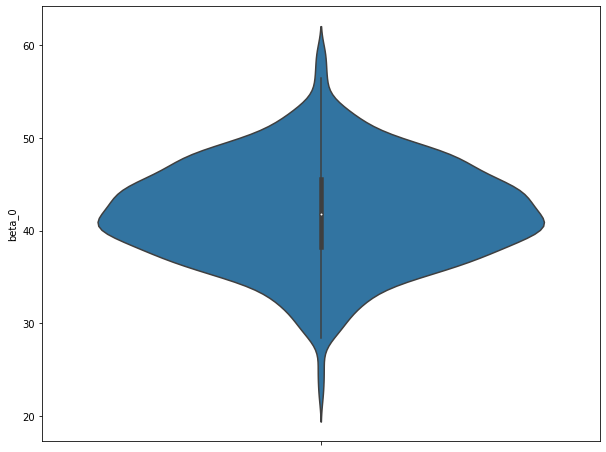

In [141]:
fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(data=betas_df, y="beta_0" ,split=True)
ax1.set_xlabel('Intercepto')

Text(0.5, 0, 'Beta 6')

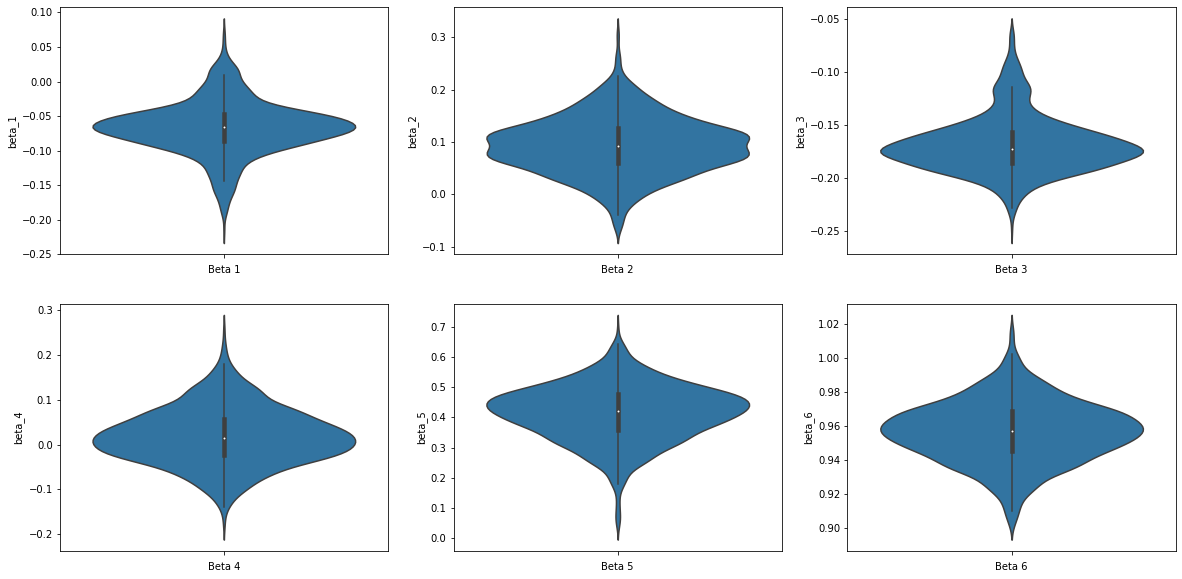

In [137]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(figsize=(20,10), ncols=3, nrows=2)
sns.violinplot(data=betas_df, y="beta_1" ,split=True, ax = ax1)
ax1.set_xlabel('Beta 1')
sns.violinplot(data=betas_df, y="beta_2" ,split=True, ax = ax2)
ax2.set_xlabel('Beta 2')
sns.violinplot(data=betas_df, y="beta_3" ,split=True, ax = ax3)
ax3.set_xlabel('Beta 3')
sns.violinplot(data=betas_df, y="beta_4" ,split=True, ax = ax4)
ax4.set_xlabel('Beta 4')
sns.violinplot(data=betas_df, y="beta_5" ,split=True, ax = ax5)
ax5.set_xlabel('Beta 5')
sns.violinplot(data=betas_df, y="beta_6" ,split=True, ax = ax6)
ax6.set_xlabel('Beta 6')

### Cargar los datos a S3 Zona Refined

In [ ]:
BETAS_DF_MODELO_0= pd.DataFrame(betas_grupo_0)
BETAS_DF_MODELO_1= pd.DataFrame(betas_grupo_1)
BETAS_DF_MODELO_2= pd.DataFrame(betas_grupo_2)

In [ ]:
#### guardar info en el bucket
BUCKET_NAME ='prr-integrador-grupo3'
s3= boto3.resource('s3')
data0= BETAS_DF_MODELO_0
data1= BETAS_DF_MODELO_1
data2= BETAS_DF_MODELO_2
s3.Bucket(BUCKET_NAME).put_object(Key='Zona-Refined/BETAS_DF_MODELO_0.csv',Body=data0)
s3.Bucket(BUCKET_NAME).put_object(Key='Zona-Refined/BETAS_DF_MODELO_1.csv',Body=data1)
s3.Bucket(BUCKET_NAME).put_object(Key='Zona-Refined/BETAS_DF_MODELO_2.csv',Body=data2)